In [1]:
# For this notebook, we've picked an instance of maxcut. Other problems are more interesting,
# but this is the one always used in the literature.

# The goal here is to setup a Maxcut QAOA instance using qiskit, and execute it on the qiskit simulator
# using the ColdQuanta API. To validate our results, we will look for the canonical ``qaoa landscape" and 
# see that it loses contrast when the noise is increased.

In [2]:
from coldquanta.qiskit_tools.coldquanta_sim_backend import ColdQuantaSimBackend
%load_ext autoreload
%autoreload 2
# Set up a 2x2 grid topology.
rows = 1
cols = 2
neutral_atom = ColdQuantaSimBackend(rows=rows, cols=cols)
neutral_atom_config = neutral_atom.configuration()
coupling_map = neutral_atom_config.coupling_map

/Users/anthonypolloreno/.pyenv/versions/3.7.4/envs/qaoa_venv/lib/python3.7/site-packages/networkx/drawing/layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


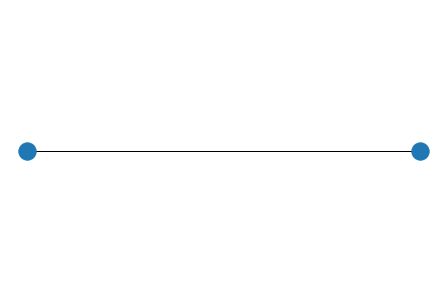

In [3]:
from networkx import Graph, draw_planar
g = Graph(coupling_map)
draw_planar(g)

In [4]:
# We will currently only accept QAOA instances on graphs isomorphic to our own -
# i.e. we are not implementing a compiler. Provide them as a dictionary.

# Uniform weights.
weights = set()
for k in coupling_map:
    weights.add((min(k), max(k)))
weights = {k: 1 for k in weights}

In [5]:
from classical_optimization.qaoa_circuits import maxcut_qaoa_circuit

In [6]:
print(maxcut_qaoa_circuit(gammas=[0,0],betas=[0,0], p=1, weights=weights, rows=rows, cols=cols))

        ┌───┐ ░                                     ░ ┌───────┐ ░ ┌─┐   
   q_0: ┤ H ├─░───────■─────────────────────■───────░─┤ RX(0) ├─░─┤M├───
        ├───┤ ░ ┌───┐ │ ┌───┐┌───────┐┌───┐ │ ┌───┐ ░ ├───────┤ ░ └╥┘┌─┐
   q_1: ┤ H ├─░─┤ H ├─■─┤ H ├┤ RZ(0) ├┤ H ├─■─┤ H ├─░─┤ RX(0) ├─░──╫─┤M├
        └───┘ ░ └───┘   └───┘└───────┘└───┘   └───┘ ░ └───────┘ ░  ║ └╥┘
meas_0: ═══════════════════════════════════════════════════════════╩══╬═
                                                                      ║ 
meas_1: ══════════════════════════════════════════════════════════════╩═
                                                                        


In [7]:
from classical_optimization.qaoa_circuits import estimate_cost

In [8]:
import numpy as np
discretization = 20
max_gamma = max_beta = np.pi
gammas = np.linspace(0, max_gamma, discretization)
betas = np.linspace(0, max_beta, discretization)

In [9]:
# Question - what does introducing correlations between gamma and beta do?
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
num_shots = 1024
experiments = []
for gamma in gammas:
    for beta in betas:
        experiments.append(maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=rows, cols=cols, weights=weights))
job = execute(experiments, backend=simulator, shots=num_shots)    
all_counts = job.result().get_counts()

In [10]:
import numpy as np
landscape = np.zeros((discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

In [166]:
float('−2.5')

ValueError: could not convert string to float: '−2.5'

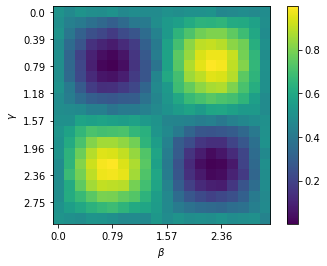

In [171]:
import matplotlib.pyplot as plt
from classical_optimization.qaoa_circuits import plot_landscape
from qiskit.visualization import plot_histogram

ax = plot_landscape(landscape, max_gamma, max_beta, colorbar=True)
#plot_histogram(all_counts[np.argmax(landscape)])

In [132]:
ax.figure.get_axes()[0].get_xticks()

array([-5.,  0.,  5., 10., 15., 20.])

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

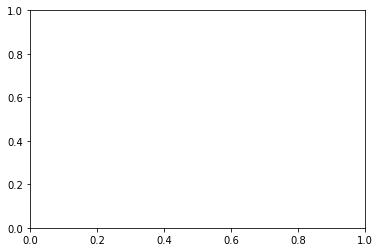

In [113]:
plt.gca().get_xticks()

# p=2

In [79]:
# You need p=2 to find the maxcut on a larger graph. Look at Farhi paper to confirm this...
discretization = 6
gammas = np.linspace(0, max_gamma, discretization)
betas = np.linspace(0, max_beta, discretization)
# Question - what does introducing correlations between gamma and beta do?
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
num_shots = 1024
experiments = []
for gamma in gammas:
    for beta in betas:
        for gamma1 in gammas:
            for beta1 in betas:
                experiments.append(maxcut_qaoa_circuit(gammas=[gamma, gamma1], betas=[beta, beta1], p=2, rows=rows, cols=cols, weights=weights))
job = execute(experiments, backend=simulator, shots=num_shots)    
all_counts = job.result().get_counts()

In [80]:
max([estimate_cost(count, weights) for count in all_counts])

0.994140625

# Now introduce noise!

In [14]:
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model

In [15]:
noise_model = create_noise_model()

In [25]:
noise_model = create_noise_model(cz_fidelity=0.7)

experiments = []
for gamma in gammas:
    for beta in betas:
        experiments.append(maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=rows, cols=cols, weights=weights))
job = execute(experiments,
              simulator,
              noise_model=noise_model,
              coupling_map=coupling_map,
              optimization_level=0,
              shots=num_shots)  
all_counts = job.result().get_counts()

In [26]:
noisy_landscape = np.zeros((discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        noisy_landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

In [38]:
xticks

array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ])

In [41]:
gammas

array([0.        , 0.16534698, 0.33069396, 0.49604095, 0.66138793,
       0.82673491, 0.99208189, 1.15742887, 1.32277585, 1.48812284,
       1.65346982, 1.8188168 , 1.98416378, 2.14951076, 2.31485774,
       2.48020473, 2.64555171, 2.81089869, 2.97624567, 3.14159265])

In [87]:
max([int(tick.get_text().replace('−','-')) for tick in ticks if tick.get_text()!=''])

20

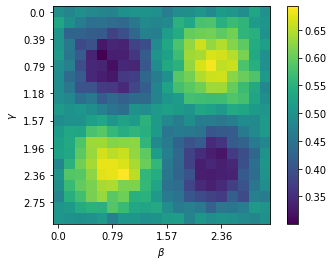

In [169]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from classical_optimization.qaoa_circuits import plot_landscape

plot_landscape(noisy_landscape, max_gamma, max_beta);

In [97]:

# plot_histogram(all_counts[np.argmax(noisy_landscape)])

# Include Classical Optimizer

In [88]:
from classical_optimization.qaoa_circuits import SCIPY_METHODS, plot_history_over_landscape
simulator = Aer.get_backend('qasm_simulator')
shots_per_point = 1000

$\gamma$,$\beta$=[0.78913366 2.3834049 ]
Max cut is 1.0


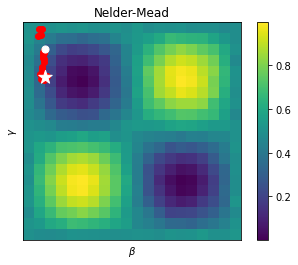

$\gamma$,$\beta$=[-3.94125264  0.7592281 ]
Max cut is 1.0


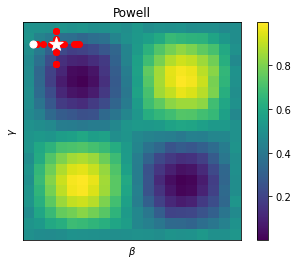

$\gamma$,$\beta$=[1.46613915 2.94991144]
Max cut is 0.53


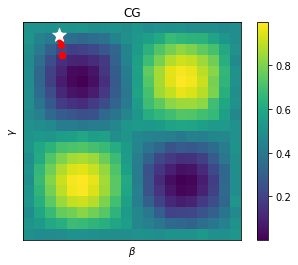

$\gamma$,$\beta$=[0.51726749 1.63479842]
Max cut is 0.579


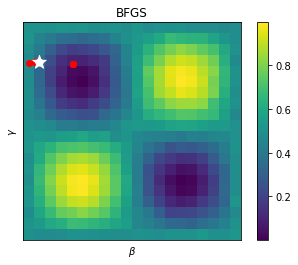

$\gamma$,$\beta$=[2.40547077 2.43746345]
Max cut is 0.007


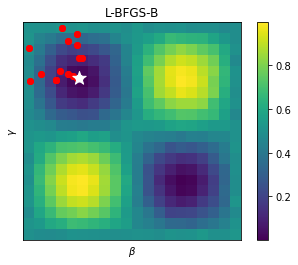

$\gamma$,$\beta$=[0.35260876 1.15637492]
Max cut is 0.251


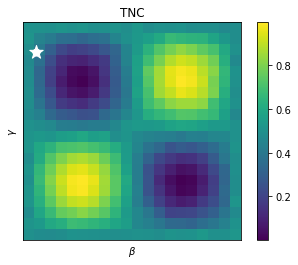

$\gamma$,$\beta$=[2.35693573 0.76408895]
Max cut is 1.0


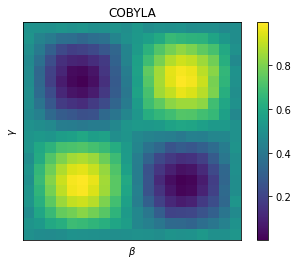

$\gamma$,$\beta$=[4834.86169231 8747.9186098 ]
Max cut is 0.519


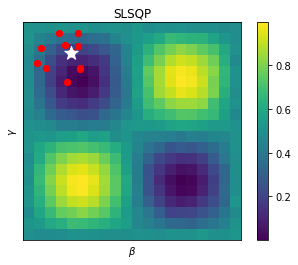

$\gamma$,$\beta$=[1.05535458 2.42010434]
Max cut is 0.94


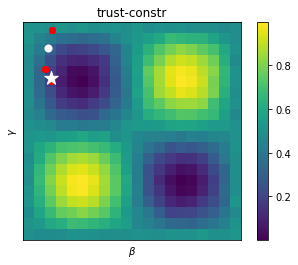

In [89]:
from classical_optimization.qaoa_circuits import SCIPY_METHODS, try_optimizer

for method in SCIPY_METHODS:
    history = []
    try_optimizer(method, simulator, neutral_atom_config.coupling_map, shots_per_point,
                  weights, max_gamma, max_beta, rows, cols, history)
    plot_history_over_landscape(history, landscape, discretization, max_gamma, max_beta)
    plt.title(method)
    plt.show()